### Elevation trend analysis based on altimeter data.
#### 1) Elevation change correction based on elevation changes on the stable region. 
#### ${dh}_{glacier-cor} = {dh}_{glacier} - {dh}_{stable}$
#### The time-series ${dh}_{glacier-cor}$ are then linear fitted by by ransac algorithm.
#### 2) Uncertainty estimation of elevation change rate. 
#### $\epsilon_{ransac} = y_i - y_{fitting}$
#### $\sigma_{dh} = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(\epsilon_{i} - \overline{\epsilon})^2} $
#### $\sigma_\frac{dh}{dt} = \frac{\sigma_{dh}}{dt}$
The n refer to the number of the years, and the i is the i-th year.
### Content:
##### 1. Icesat-1
<font color=pink> **!!!! Note: the Icesat-1 data are very sparse and the calculation for tiles is not conduct.** </font> 
- 1.1 Area weighted elevation differece and uncertainty estimation.
- 1.2 Write out the result.
##### 2. Icesat-2.
- 2.1 Result for overall setp region.
- 2.2 Result by tiles.
- 2.3 Result by bins
- 2.4 Write out the result.
##### 3. Cryosat-2.
<font color=pink> **!!!! Note: the cryosat-2 eolis point data only contain the data on the glacier region. therefore, the elevation correction for yearly elevation changes is not conduct for the eolis data.  
However, to align the elevation change with that derived by another data, the global bias of elevation change is removed by using the mean elevation change difference with the icesat-2 derived result.** 
</font> 

- 3.1 Result for overall setp region.   
- 3.2 Result by tiles.   
- 3.3 Result by bins.     
- 3.4 Write out the result.     



In [1]:
import os 
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from utils.tiles_bins_weighting import stat_bins_weighting, stat_tiles_weighting
from utils.tiles_bins_weighting import stat_bins_tiles_weighting, stat_tiles_bins_weighting
from utils.ransac_fitting import ransac_fitting


In [2]:
### Read in
path_sta_isat1 = 'data/icesat-1/stat_dif_isat1_tiles_sub.nc'
path_sta_isat2 = 'data/icesat-2/stat_dif_isat2_tiles_sub_bins.nc'
path_sta_cryo2 = 'data/cryosat-2/stat_dif_cryo2_tiles_sub_bins.nc'
### Write out
path_result_isat1 = 'data/ele-change-result/ele_change_isat1_tiles_sub.nc'
path_result_isat2 = 'data/ele-change-result/ele_change_isat2_tiles_sub.nc'
path_result_cryo2 = 'data/ele-change-result/ele_change_cryo2_tiles_sub.nc'



In [3]:
stat_isat1_xr = xr.open_dataset(path_sta_isat1)
stat_isat2_xr = xr.open_dataset(path_sta_isat2)
stat_cryo2_xr = xr.open_dataset(path_sta_cryo2)
years_isat1, years_isat2, years_cryo2 = stat_isat1_xr.years.values, stat_isat2_xr.years.values, stat_cryo2_xr.years.values
bins_id_isat2, bins_id_cryo2 = stat_isat2_xr.bins_id.values, stat_cryo2_xr.bins_id.values
tiles_id_isat1, tiles_id_isat2, tiles_id_cryo2 = stat_isat1_xr.tiles_id.values, stat_isat2_xr.tiles_id.values, stat_cryo2_xr.tiles_id.values
years_cryo2


array(['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017',
       '2018', '2019', '2020', '2021', '2022'], dtype=object)

### **1. ICESAT-1** 
#### 1.1 Area weighted elevation differece and robust linear fitting by ransac algorithm.


In [4]:
mean_setp_glacier_isat1, std_setp_glacier_isat1 = stat_tiles_weighting(mean_tiles=stat_isat1_xr['mean_glacier_tiles_years'], \
                                            std_tiles=stat_isat1_xr['std_glacier_tiles_years'], glacier_area_tiles=stat_isat1_xr['area_glacier_tiles'])
mean_setp_stable_isat1, std_setp_stable_isat1 = stat_tiles_weighting(mean_tiles=stat_isat1_xr['mean_stable_tiles_years'], \
                                            std_tiles=stat_isat1_xr['std_stable_tiles_years'], glacier_area_tiles=stat_isat1_xr['area_glacier_tiles'])
mean_setp_glacier_cor_isat1 = mean_setp_glacier_isat1 - mean_setp_stable_isat1   ### elevation change correction.
mean_setp_glacier_filtered_isat1, mean_setp_glacier_fitting_isat1, rate_setp_glacier_isat1 = ransac_fitting(x=np.arange(len(years_isat1)), y=mean_setp_glacier_cor_isat1, thre_mask=50)
### standard deviation of elevation change.
std_setp_glacier_cor_isat1 = np.sqrt(np.square(std_setp_glacier_isat1) + np.square(std_setp_stable_isat1)) 
print('Elevation change rate by icesat1:', rate_setp_glacier_isat1)



Elevation change rate by icesat1: -1.179263019560164


#### 1.2 Uncertainty estimation

In [5]:
#### 1. Time interval: 2000-2022
epsilon = mean_setp_glacier_cor_isat1.values - mean_setp_glacier_fitting_isat1
sigma_dh = np.std(epsilon)
sigma_dh_dt_isat1 = sigma_dh/len(years_isat1)
print('sigma_dh:', sigma_dh)
print('sigma_dh_dt of Icesat-1:', sigma_dh_dt_isat1)


sigma_dh: 3.0808535352352364
sigma_dh_dt of Icesat-1: 0.44012193360503377


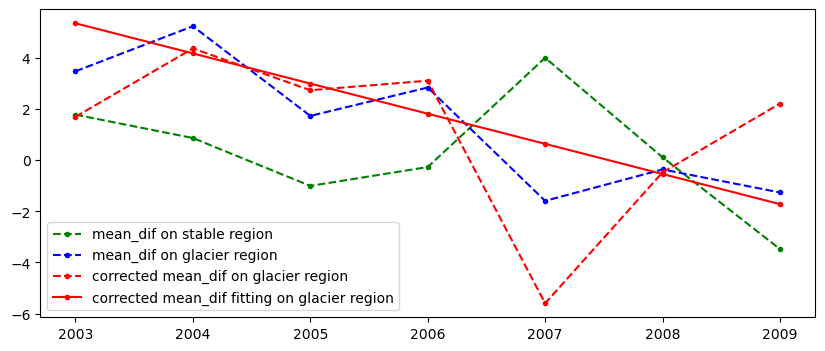

In [6]:
plt.figure(figsize=(10,4))
plt.plot(years_isat1, mean_setp_stable_isat1, '.--g', label='mean_dif on stable region')
plt.plot(years_isat1, mean_setp_glacier_isat1, '.--b', label='mean_dif on glacier region')
plt.plot(years_isat1, mean_setp_glacier_cor_isat1, '.--r', label='corrected mean_dif on glacier region')
plt.plot(years_isat1, mean_setp_glacier_fitting_isat1, '.-r', label='corrected mean_dif fitting on glacier region')
plt.legend()



#### 1.3 Result by tiles.

In [7]:
rate_tiles_isat1, rate_tiles_error_isat1, mean_tiles_glacier_isat1_cor, std_tiles_stable_isat1 = [], [], [], []

for tile_id in tiles_id_isat1:
  # tile_id =  'tile_275_970'
  print(tile_id)
  mean_tile_glacier = stat_isat1_xr['mean_glacier_tiles_years'].sel(tiles_id=tile_id).values
  mean_tile_stable = stat_isat1_xr['mean_stable_tiles_years'].sel(tiles_id = tile_id).values
  std_tile_stable = stat_isat1_xr['std_stable_tiles_years'].sel(tiles_id = tile_id).values
  mean_tile_glacier_cor = mean_tile_glacier - mean_tile_stable        ### Elevation change correction
  mean_tiles_glacier_isat1_cor.append(mean_tile_glacier_cor)
  std_tiles_stable_isat1.append(std_tile_stable)
  ids_valid = np.where(~np.isnan(mean_tile_glacier_cor))[0]
  if ids_valid.shape[0]>2:
    mean_tile_glacier_cor_filtered, mean_tile_glacier_cor_fitting, rate_tile_glacier_cor = \
                                          ransac_fitting(x=np.arange(len(years_isat1)), y=mean_tile_glacier_cor, thre_mask=50)
    rate_tiles_isat1.append(rate_tile_glacier_cor)
    ## Uncertainty.
    epsilon = mean_tile_glacier_cor - mean_tile_glacier_cor_fitting
    sigma_dh = np.nanstd(epsilon)
    sigma_dh_dt = sigma_dh/len(years_isat1)
    rate_tiles_error_isat1.append(sigma_dh_dt)
  else: 
    rate_tiles_isat1.append(np.nan)
    rate_tiles_error_isat1.append(np.nan)
  # break

mean_tiles_glacier_isat1_cor = np.stack(mean_tiles_glacier_isat1_cor, axis=0) 
std_tiles_stable_isat1 = np.stack(std_tiles_stable_isat1, axis=0)
mean_tiles_glacier_isat1_cor.shape



tile_270_965
tile_270_970
tile_270_975
tile_270_980
tile_270_985
tile_275_960
tile_275_965
tile_275_970
tile_275_975
tile_275_980
tile_275_985
tile_280_940
tile_280_945
tile_280_950
tile_280_955
tile_280_960
tile_280_970
tile_280_975
tile_280_980
tile_280_985
tile_285_940
tile_285_950
tile_285_955
tile_285_960
tile_285_965
tile_285_970
tile_285_975
tile_285_980
tile_285_985
tile_290_910
tile_290_915
tile_290_920
tile_290_925
tile_290_930
tile_290_935
tile_290_940
tile_290_945
tile_290_950
tile_290_955
tile_290_960
tile_290_965
tile_290_970
tile_290_975
tile_290_980
tile_295_910
tile_295_925
tile_295_930
tile_295_935
tile_295_940
tile_295_945
tile_295_950
tile_295_955
tile_295_960
tile_295_965
tile_295_970
tile_295_975
tile_295_980
tile_295_985
tile_300_910
tile_300_915
tile_300_920
tile_300_930
tile_300_935
tile_300_940
tile_300_945
tile_300_950
tile_300_955
tile_300_960
tile_300_965
tile_305_915
tile_305_920
tile_305_925
tile_305_930
tile_305_935
tile_305_945
tile_305_950
tile_305_955

(96, 7)

#### 1.3 Write out the result.

In [8]:
result_isat1_xr =xr.Dataset(
        {
        'ele_change_cor_setp': (["years"], mean_setp_glacier_cor_isat1.values),
        'ele_change_cor_error_setp': (["years"], std_setp_stable_isat1.values),
        'ele_change_cor_fitting_setp': (["years"], mean_setp_glacier_fitting_isat1),
        'ele_change_cor_tiles': (['tiles_id', 'years'], mean_tiles_glacier_isat1_cor), 
        'ele_change_cor_error_tiles': (['tiles_id', 'years'], std_tiles_stable_isat1), 
        'rate_setp': rate_setp_glacier_isat1,
        'rate_error_setp': sigma_dh_dt_isat1,
        },
        coords={
                'tiles_id': tiles_id_isat1,
                'years': years_isat1,
                })
if os.path.exists(path_result_isat1): os.remove(path_result_isat1)
result_isat1_xr.to_netcdf(path_result_isat1)
result_isat1_xr


<xarray.Dataset>
Dimensions:                      (years: 7, tiles_id: 96)
Coordinates:
  * tiles_id                     (tiles_id) object 'tile_270_965' ... 'tile_3...
  * years                        (years) object '2003' '2004' ... '2008' '2009'
Data variables:
    ele_change_cor_setp          (years) float64 1.697 4.374 ... -0.4739 2.217
    ele_change_cor_error_setp    (years) float64 10.41 9.218 ... 12.04 10.05
    ele_change_cor_fitting_setp  (years) float64 5.357 4.178 ... -0.5392 -1.718
    ele_change_cor_tiles         (tiles_id, years) float64 nan nan ... nan nan
    ele_change_cor_error_tiles   (tiles_id, years) float64 nan nan ... 3.45
    rate_setp                    float64 -1.179
    rate_error_setp              float64 0.4401

### 2. ICESAT-2

#### 2.1 For the overall setp region.

In [9]:
mean_setp_stable_isat2, std_setp_stable_isat2 = stat_tiles_weighting(mean_tiles = stat_isat2_xr['mean_stable_tiles'], \
                                                                    std_tiles = stat_isat2_xr['std_stable_tiles'], 
                                                                    glacier_area_tiles = stat_isat2_xr['area_glacier_tiles'])

### From bins weighting to tiles weighting.
mean_tiles_glacier_isat2, std_tiles_glacier_isat2, mean_setp_glacier_isat2, std_setp_glacier_isat2 = \
                                                stat_bins_tiles_weighting(mean_tiles_bins=stat_isat2_xr['mean_glacier_tiles_bins'], \
                                                                    std_tiles_bins=stat_isat2_xr['std_glacier_tiles_bins'], 
                                                                    glacier_area_tiles_bins=stat_isat2_xr['area_glacier_tiles_bins'])

#### elevation change correction
mean_setp_glacier_cor_isat2 = mean_setp_glacier_isat2.values - mean_setp_stable_isat2.values
### standard deviation of the corercted elevation change.
std_setp_glacier_cor_isat2 = np.sqrt(np.square(std_setp_stable_isat2.values) + np.square(std_setp_glacier_isat2.values)) 



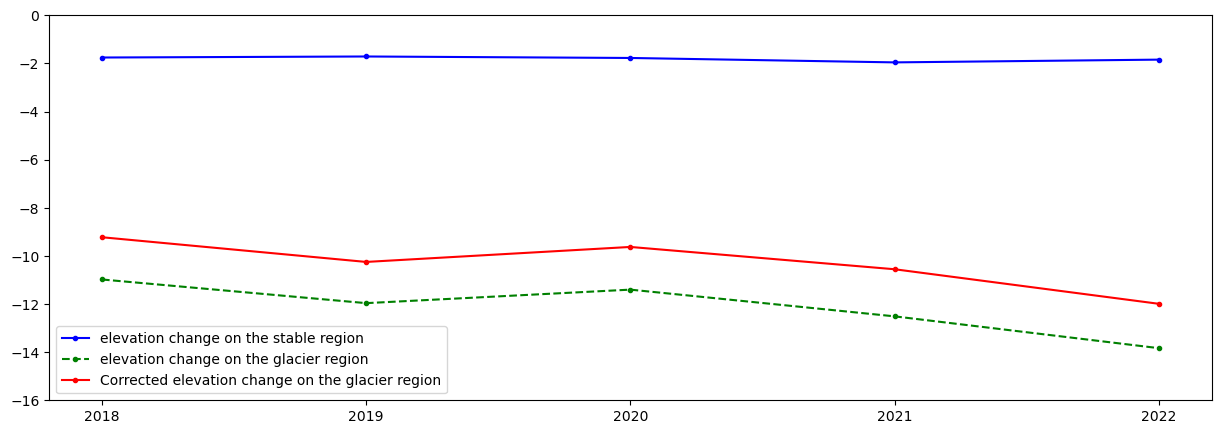

In [10]:
plt.figure(figsize=(15,5))
plt.plot(years_isat2, mean_setp_stable_isat2, '.-b', label='elevation change on the stable region')
plt.plot(years_isat2, mean_setp_glacier_isat2, '.--g', label='elevation change on the glacier region')   ### 
plt.plot(years_isat2, mean_setp_glacier_cor_isat2, '.-r', label='Corrected elevation change on the glacier region')   ### 
plt.ylim(top=0, bottom=-16)
plt.legend()



##### Robust linear fitting by ransac algorithm.

In [11]:
mean_setp_glacier_cor_filtered_isat2, mean_setp_glacier_cor_fitting_isat2, rate_setp_glacier_cor_isat2 \
                                        = ransac_fitting(x=np.arange(len(years_isat2)), y=mean_setp_glacier_cor_isat2, thre_mask=50)
print('Elevation change rate by Icesat-2:', rate_setp_glacier_cor_isat2)



Elevation change rate by Icesat-2: -0.33673009772920975


#### Uncertainty estimation


In [12]:
epsilon = mean_setp_glacier_cor_isat2 - mean_setp_glacier_cor_fitting_isat2
sigma_dh = np.std(epsilon)
sigma_dh_dt_isat2 = sigma_dh/len(years_isat2)
# print('sigma_dh:', sigma_dh)
print('sigma_dh_dt of Icesat-2:', sigma_dh_dt_isat2)


sigma_dh_dt of Icesat-2: 0.11772605095874397


#### 2.2 Result by tiles.

In [13]:
rate_tiles_isat2, rate_tiles_error_isat2, mean_tiles_glacier_isat2_cor = [], [], []
for tile_id in tiles_id_isat2:
  # tile_id =  'tile_27_98'
  mean_tile_glacier = mean_tiles_glacier_isat2.sel(tiles_id=tile_id).values
  mean_tile_stable = stat_isat2_xr['mean_stable_tiles'].sel(tiles_id = tile_id).values
  std_tile_stable = stat_isat2_xr['std_stable_tiles'].sel(tiles_id = tile_id).values
  mean_tile_glacier_cor = mean_tile_glacier - mean_tile_stable    ### elevation change correction
  mean_tiles_glacier_isat2_cor.append(mean_tile_glacier_cor)
  ids_valid = np.where(~np.isnan(mean_tile_glacier_cor))[0]
  if ids_valid.shape[0]>2:
    mean_tile_glacier_cor_filtered, mean_tile_glacier_cor_fitting, rate_tile_glacier_cor = \
                                          ransac_fitting(x=np.arange(len(years_isat2)), y=mean_tile_glacier_cor, thre_mask=50)
    rate_tiles_isat2.append(rate_tile_glacier_cor)
    ## Uncertainty.
    epsilon = mean_tile_glacier_cor - mean_tile_glacier_cor_fitting
    sigma_dh = np.nanstd(epsilon)
    sigma_dh_dt = sigma_dh/len(years_isat2)
    rate_tiles_error_isat2.append(sigma_dh_dt)
  else: 
    rate_tiles_isat2.append(np.nan)
    rate_tiles_error_isat2.append(np.nan)

mean_tiles_glacier_isat2_cor = np.stack(mean_tiles_glacier_isat2_cor, axis=0) 
mean_tiles_glacier_isat2_cor.shape
  # break



(101, 5)

##### 2.3 Result by bins ( ! no correction)

In [14]:
### From bins weighting to tiles weighting.
mean_bins_glacier_isat2, std_bins_glacier_isat2, mean_setp_glacier_isat2, std_setp_glacier_isat2 = \
                                                stat_tiles_bins_weighting(mean_tiles_bins=stat_isat2_xr['mean_glacier_tiles_bins'], \
                                                                    std_tiles_bins=stat_isat2_xr['std_glacier_tiles_bins'], 
                                                                    glacier_area_tiles_bins=stat_isat2_xr['area_glacier_tiles_bins'])
rate_bins_isat2, rate_bins_error_isat2, ele_change_bins = [], [], []

for bin_id in bins_id_isat2:
    ele_change_bin = mean_bins_glacier_isat2.sel(bins_id = bin_id).values
    ele_change_bin = np.where(ele_change_bin == 0, np.nan, ele_change_bin)
    ids_valid = np.where(~np.isnan(ele_change_bin))[0]
    if ids_valid.shape[0]>2:
        mean_bin_glacier_filtered, mean_bin_glacier_fitting, rate_bin_glacier = ransac_fitting(x=np.arange(len(years_isat2)), y=ele_change_bin, thre_mask=50)
        rate_bins_isat2.append(rate_bin_glacier)
        ele_change_bins.append(ele_change_bin)
        ## Uncertainty.
        epsilon =  ele_change_bin - mean_bin_glacier_fitting
        sigma_dh = np.nanstd(epsilon)
        sigma_dh_dt = sigma_dh/len(years_isat2)
        rate_bins_error_isat2.append(sigma_dh_dt)
    else:
        rate_bins_isat2.append(np.nan)
        ele_change_bins.append(np.nan)
        rate_bins_error_isat2.append(np.nan)
area_glacier_bins = stat_isat2_xr['area_glacier_tiles_bins'].sum(dim='tiles_id').values




#### 2.4 Write out the result.

In [15]:
### 3) write out statistic of stable region to the xarray .nc file.
tiles_lat, tiles_lon = [], []
for tile_id in tiles_id_isat2:
    tiles_lat.append(int(tile_id.split('_')[1]))
    tiles_lon.append(int(tile_id.split('_')[2]))

### Conver to xarray data.
result_isat2_xr =xr.Dataset(
        {
        'tiles_lat': (["tiles_id"], tiles_lat),
        'tiles_lon': (["tiles_id"], tiles_lon),
        "area_glacier_tiles": (["tiles_id"], stat_isat2_xr['area_glacier_tiles'].values),
        "area_glacier_bins": (["bins_id"], area_glacier_bins),
        "ele_change_cor_setp": (["years"], mean_setp_glacier_cor_isat2),
        "ele_change_cor_fitting_setp": (["years"], mean_setp_glacier_cor_fitting_isat2),
        "ele_change_cor_error_setp": (["years"], std_setp_stable_isat2.values),
        "ele_change_cor_tiles": (["tiles_id", "years"], mean_tiles_glacier_isat2_cor),
        "ele_change_cor_error_tiles": (["tiles_id", "years"], stat_isat2_xr.std_stable_tiles.values),
        'rate_setp': rate_setp_glacier_cor_isat2,
        'rate_error_setp': sigma_dh_dt_isat2, 
        'rate_tiles': (["tiles_id"], rate_tiles_isat2),
        'rate_error_tiles': (["tiles_id"], rate_tiles_error_isat2),
        'rate_bins': (["bins_id"], rate_bins_isat2),
        'rate_error_bins': (["bins_id"], rate_bins_error_isat2), 
        },
        coords={'tiles_id': tiles_id_isat2,
                'bins_id': bins_id_isat2,
                'years': years_isat2})

if os.path.exists(path_result_isat2): os.remove(path_result_isat2)
result_isat2_xr.to_netcdf(path_result_isat2)


### 3. Cryosat-2

#### 3.1 For the overall setp region. (! no stable region-based correction, but overall elevation change bias correction is performed by icesat-2 derived result.)

In [16]:
stat_cryo2_xr


<xarray.Dataset>
Dimensions:                  (tiles_id: 76, bins_id: 50, years: 13)
Coordinates:
  * tiles_id                 (tiles_id) object 'tile_275_980' ... 'tile_315_955'
  * bins_id                  (bins_id) object '2500-2600' ... '7400-7500'
  * years                    (years) object '2010' '2011' ... '2021' '2022'
Data variables:
    area_glacier_tiles       (tiles_id) float64 ...
    area_glacier_tiles_bins  (tiles_id, bins_id) float64 ...
    mean_glacier_tiles_bins  (tiles_id, bins_id, years) float64 ...
    std_glacier_tiles_bins   (tiles_id, bins_id, years) float64 ...
    mean_stable_tiles        (tiles_id, years) float64 ...
    std_stable_tiles         (tiles_id, years) float64 ...

In [17]:
### Bins and tiles-based glacier area weighted elevation change.
mean_setp_stable_cryo2, std_setp_stable_cryo2 = stat_tiles_weighting(mean_tiles = stat_cryo2_xr['mean_stable_tiles'], \
                                                                    std_tiles = stat_cryo2_xr['std_stable_tiles'], 
                                                                    glacier_area_tiles = stat_cryo2_xr['area_glacier_tiles'])
mean_tiles_glacier_cryo2, std_tiles_glacier_cryo2, mean_setp_glacier_cryo2, std_setp_glacier_cryo2 = \
                                                stat_bins_tiles_weighting(mean_tiles_bins=stat_cryo2_xr['mean_glacier_tiles_bins'], \
                                                                    std_tiles_bins=stat_cryo2_xr['std_glacier_tiles_bins'], 
                                                                    glacier_area_tiles_bins=stat_cryo2_xr['area_glacier_tiles_bins'])
ids_isat2_of_cryo2 = [np.where(year == years_cryo2)[0].item() for year in years_isat2]
bias_cryo2_isat2 = (mean_setp_glacier_cor_isat2-mean_setp_glacier_cryo2[ids_isat2_of_cryo2]).mean().values
mean_tiles_glacier_cor_cryo2, mean_setp_glacier_cor_cryo2 = mean_tiles_glacier_cryo2+bias_cryo2_isat2, mean_setp_glacier_cryo2+bias_cryo2_isat2
bias_cryo2_isat2



array(7.70005177)

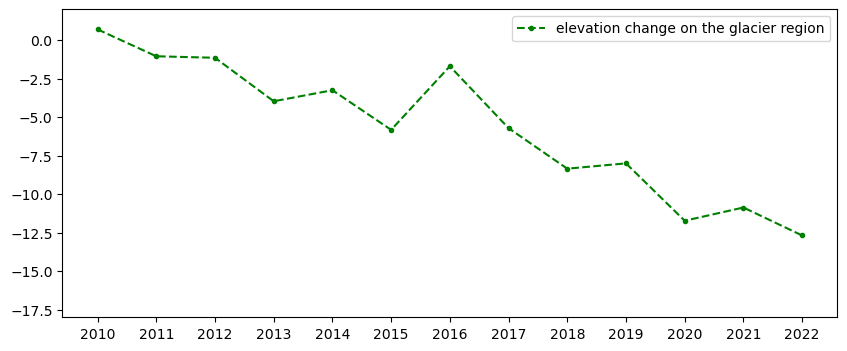

In [19]:
plt.figure(figsize=(10,4))
plt.plot(years_cryo2, mean_setp_glacier_cor_cryo2, '.--g', label='elevation change on the glacier region')   ### 
plt.ylim(top=2, bottom=-18)
plt.legend()


##### Robust linear fitting by ransac algorithm.

In [20]:
mean_setp_glacier_cor_filtered_cryo2, mean_setp_glacier_cor_fitting_cryo2, rate_setp_glacier_cor_cryo2 \
                                = ransac_fitting(x=np.arange(len(years_cryo2)), y=mean_setp_glacier_cor_cryo2, thre_mask=50)
print('Elevation change rate by cryo-2:', rate_setp_glacier_cor_cryo2)


Elevation change rate by cryo-2: -1.0653360984422091


#### Uncertainty estimation

In [21]:
epsilon = mean_setp_glacier_cor_cryo2.values - mean_setp_glacier_cor_fitting_cryo2
sigma_dh = np.std(epsilon)
sigma_dh_dt_cryo2 = sigma_dh/len(years_cryo2)
# print('sigma_dh:', sigma_dh)
print('sigma_dh_dt of Cryo-2:', sigma_dh_dt_cryo2)


sigma_dh_dt of Cryo-2: 0.10855890982904626


#### 3.2 Result by tiles. (! no stable region correction but overall elevation change bias correction is performed.)


In [22]:
rate_tiles_cor_cryo2, rate_tiles_error_cor_cryo2 = [], []
for tile_id in tiles_id_cryo2:
  # tile_id =  'tile_27_98'
  mean_tile_glacier_cor = mean_tiles_glacier_cor_cryo2.sel(tiles_id=tile_id).values
  ids_valid = np.where(~np.isnan(mean_tile_glacier_cor))[0]
  if ids_valid.shape[0]>2:
    mean_tile_glacier_cor_filtered, mean_tile_glacier_cor_fitting, rate_tile_glacier_cor = \
                                            ransac_fitting(x=np.arange(len(years_cryo2)), y=mean_tile_glacier_cor, thre_mask=50)
    rate_tiles_cor_cryo2.append(rate_tile_glacier_cor)
    ## Uncertainty.
    epsilon = mean_tile_glacier_cor - mean_tile_glacier_cor_fitting
    sigma_dh = np.nanstd(epsilon)
    sigma_dh_dt = sigma_dh/len(years_cryo2)
    rate_tiles_error_cor_cryo2.append(sigma_dh_dt)
  else: 
    rate_tiles_cor_cryo2.append(np.nan)
    rate_tiles_error_cor_cryo2.append(np.nan)

rate_tiles_cor_cryo2
rate_tiles_error_cor_cryo2


[nan,
 nan,
 nan,
 1.4003885190209007,
 0.3164656508381248,
 0.9751848368594553,
 nan,
 0.6384537561916505,
 0.9769192955629157,
 0.3820529680642736,
 0.6775561662381564,
 1.1587052386345738,
 0.19644806318748342,
 1.1558800978604522,
 0.8165810368908425,
 0.3112332854608705,
 0.8574033362611451,
 0.37578594396951465,
 nan,
 0.7132130999396625,
 nan,
 0.8548836242147537,
 0.14395269893122728,
 0.25138204727275176,
 0.2249522304525803,
 0.7053924030164527,
 0.5895005267488233,
 nan,
 1.1503585780732544,
 0.39626514718262507,
 0.5475909599720441,
 0.5012366612882725,
 nan,
 0.454160566202943,
 0.33834040697820017,
 0.42871953227166826,
 0.34247021466840716,
 0.3638299232711647,
 0.32404002577092145,
 nan,
 1.1352464291376299,
 0.7338106316189248,
 0.20814056793070093,
 0.2914572289959058,
 0.4819567370320055,
 1.6467349806485847,
 0.2516723785400605,
 0.26440239710481994,
 0.8494710081391381,
 1.729679527063155,
 nan,
 nan,
 0.5053184854125773,
 3.5628789671250134,
 nan,
 0.1855688541130

##### 3.3 Result by bins (! no correction)

In [18]:
### From bins weighting to tiles weighting.
mean_bins_glacier_cor_cryo2, std_bins_glacier_cor_cryo2, mean_setp_glacier_cor_cryo2, std_setp_glacier_cor_cryo2 = \
                                                stat_tiles_bins_weighting(mean_tiles_bins=stat_cryo2_xr['mean_glacier_tiles_bins'], \
                                                                    std_tiles_bins=stat_cryo2_xr['std_glacier_tiles_bins'], 
                                                                    glacier_area_tiles_bins=stat_cryo2_xr['area_glacier_tiles_bins'])
### Elevation change bias correction for bins.
mean_bins_glacier_cor_cryo2, mean_setp_glacier_cor_cryo2 = mean_bins_glacier_cor_cryo2+bias_cryo2_isat2, mean_setp_glacier_cor_cryo2+bias_cryo2_isat2
rate_bins_cor_cryo2, rate_bins_error_cor_cryo2, ele_change_bins_cor = [], [], []

for bin_id in bins_id_cryo2:
    ele_change_bin_cor = mean_bins_glacier_cor_cryo2.sel(bins_id = bin_id).values
    ele_change_bin_cor = np.where(ele_change_bin_cor == 0, np.nan, ele_change_bin_cor)
    ids_valid = np.where(~np.isnan(ele_change_bin_cor))[0]
    if ids_valid.shape[0]>2:
        mean_bin_glacier_cor_filtered, mean_bin_glacier_cor_fitting, rate_bin_glacier_cor = ransac_fitting(x=np.arange(len(years_cryo2)), y=ele_change_bin_cor, thre_mask=50)
        rate_bins_cor_cryo2.append(rate_bin_glacier_cor)
        ele_change_bins_cor.append(ele_change_bin_cor)
        ## Uncertainty.
        epsilon =  ele_change_bin_cor - mean_bin_glacier_cor_fitting
        sigma_dh = np.nanstd(epsilon)
        sigma_dh_dt = sigma_dh/len(years_cryo2)
        rate_bins_error_cor_cryo2.append(sigma_dh_dt)
    else:
        rate_bins_cor_cryo2.append(np.nan)
        ele_change_bins_cor.append(np.nan)
        rate_bins_error_cor_cryo2.append(np.nan)
area_glacier_bins = stat_cryo2_xr['area_glacier_tiles_bins'].sum(dim='tiles_id').values



##### 3.4 Write out the result.

In [24]:
tiles_lat, tiles_lon = [], []
for tile_id in tiles_id_cryo2:
    tiles_lat.append(int(tile_id.split('_')[1]))
    tiles_lon.append(int(tile_id.split('_')[2]))

### Conver to xarray data.
result_cryo2_xr =xr.Dataset(
        {
        'tiles_lat': (["tiles_id"], tiles_lat),
        'tiles_lon': (["tiles_id"], tiles_lon),
        "area_glacier_tiles": (["tiles_id"], stat_cryo2_xr['area_glacier_tiles'].values),
        "area_glacier_bins": (["bins_id"], area_glacier_bins),
        "ele_change_cor_setp": (["years"], mean_setp_glacier_cor_cryo2.values),
        "ele_change_cor_error_setp": (["years"], std_setp_stable_cryo2.values),
        "ele_change_cor_fitting_setp": (["years"], mean_setp_glacier_cor_fitting_cryo2),
        "ele_change_cor_tiles": (['tiles_id', "years"], mean_tiles_glacier_cor_cryo2.values),
        'rate_setp': rate_setp_glacier_cor_cryo2,
        'rate_error_setp': sigma_dh_dt_cryo2, 
        'rate_tiles': (["tiles_id"], rate_tiles_cor_cryo2),
        'rate_error_tiles': (["tiles_id"], rate_tiles_error_cor_cryo2),
        'rate_bins': (["bins_id"], rate_bins_cor_cryo2),
        'rate_error_bins': (["bins_id"], rate_bins_error_cor_cryo2), 
        },
        coords={'tiles_id': tiles_id_cryo2,
                'bins_id': bins_id_cryo2,
                'years': years_cryo2})

if os.path.exists(path_result_cryo2): os.remove(path_result_cryo2)
result_cryo2_xr.to_netcdf(path_result_cryo2)
